# word2vec (Negative sampling skipgram VS Normal Skipgram)

## 1.Load data

### import library

In [3]:
import numpy as np 
import torch 
import torch.nn as nn
from collections import Counter
import torch.optim as optim 
import matplotlib.pyplot as plt 
import spacy
import pandas as pd 
import time
import random
from numpy import dot
from numpy.linalg import norm
nlp = spacy.load("en_core_web_sm")

### Load corpus data from CSV File

In [4]:
df = pd.read_csv('corpus.csv')
all_text = df.text

## 2.Tokenized

In [5]:
corpus_tokenized_str = []
for doc in all_text :
    for token in nlp(doc) :
        corpus_tokenized_str.append(str(token))


In [6]:
corpus_tokenized_str[:10]

[' ', 'Stuning', 'even', 'for', 'the', 'non', '-', 'gamer', ':', 'This']

In [7]:
vocabs = list(set(corpus_tokenized_str))
vocabs[:10]

['still',
 'remarkable',
 'choice',
 'all',
 'lot',
 'weight',
 'done',
 'finds',
 'helps',
 'corner']

## 3.Numerization

In [8]:
word_2_idx = {v: idx for idx, v in enumerate(vocabs)}

In [9]:
print(word_2_idx["Japan"]) #See index of word "Japan"

737


In [10]:
vocabs.append('<UNK>')
word_2_idx['<UNK>'] = len(word_2_idx) 

In [11]:
word_2_idx

{'<': 0,
 'shocked': 1,
 'San': 2,
 'deep': 3,
 'try': 4,
 'chefs': 5,
 'vignettes': 6,
 'gotten': 7,
 'cost': 8,
 'appear': 9,
 'non': 10,
 'water': 11,
 'Scar': 12,
 'back': 13,
 'price': 14,
 'Good': 15,
 'absolutle': 16,
 'Xenogears': 17,
 'label': 18,
 'published': 19,
 'most': 20,
 'Wish': 21,
 'end': 22,
 'ill': 23,
 'Read': 24,
 'Delicious': 25,
 'Gale': 26,
 'Worst': 27,
 'show': 28,
 'poor': 29,
 'count': 30,
 'Ando': 31,
 'o': 32,
 'just': 33,
 'skills': 34,
 'though': 35,
 'once': 36,
 'pencil': 37,
 'Windows': 38,
 'scratches': 39,
 'churning': 40,
 'Veronica': 41,
 'since': 42,
 'normaly': 43,
 'cover': 44,
 'technically': 45,
 'anywhere': 46,
 'Which': 47,
 'put': 48,
 'struggled': 49,
 'picture': 50,
 'BIG': 51,
 'white': 52,
 'glaringly': 53,
 '#': 54,
 'Sea': 55,
 'happy': 56,
 'she': 57,
 'room': 58,
 'lot': 59,
 'wonder': 60,
 'Debacle': 61,
 'Disk': 62,
 'BY': 63,
 'does': 64,
 'varies': 65,
 'creating': 66,
 'designed': 67,
 'Old': 68,
 'mix': 69,
 'sends': 70,
 '

## 4.Prepare data

In [11]:
def random_batch(batch_size, corpus):
    skipgrams = []
    #for each corpus
    for sent in corpus_tokenized_str:
        try :
            for i in range(2, len(sent) - 2): #start from 1 to second last
                center_word = word_2_idx[sent[i]]
                outside_words = [word_2_idx[sent[i-2]], word_2_idx[sent[i-1]], word_2_idx[sent[i+1]], word_2_idx[sent[i+2]]]  #window_size = 2
                for o in outside_words:
                    skipgrams.append([center_word, o])
        except :
            pass               
    #only get a batch, not the entire list
    random_inputs, random_labels = [], []   
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
             
    #appending some list of inputs and labels
    
    for index in random_index:
        random_inputs.append([skipgrams[index][0]])  #center words, this will be a shape of (1, ) --> (1, 1) for modeling
        random_labels.append([skipgrams[index][1]])
        
    return np.array(random_inputs), np.array(random_labels)

## 5.Negative sampling

In [12]:
Z = 0.001
unigram_table = []

In [13]:
word_count = Counter(corpus_tokenized_str)
num_total_words = sum([c for w, c in word_count.items()])
for vo in vocabs:
    unigram_table.extend([vo] * int(((word_count[vo]/num_total_words)**0.75)/Z))

In [14]:
Counter(unigram_table)

Counter({'still': 3,
         'remarkable': 1,
         'choice': 2,
         'all': 15,
         'lot': 3,
         'weight': 1,
         'done': 1,
         'finds': 1,
         'helps': 1,
         'corner': 1,
         'not': 24,
         'reader': 1,
         'Illusion': 1,
         'acclaimed': 1,
         'color': 1,
         'Pull': 1,
         'straight': 1,
         'send': 1,
         'compression': 3,
         'anymore': 1,
         'garter': 1,
         'is': 44,
         'Scars': 1,
         'by': 9,
         '90s': 1,
         "'m": 7,
         'greatest': 1,
         'titled': 1,
         'tracks': 2,
         'feat': 1,
         'please': 2,
         'disgusted': 1,
         'SEA': 2,
         'absolute': 2,
         'DVD': 11,
         'society': 1,
         'remember': 1,
         'has': 9,
         '8': 1,
         'Surrounding': 1,
         'script': 1,
         'Rather': 1,
         'VERY': 1,
         'All': 3,
         'boorish': 1,
         'Please': 1,
       

In [15]:
batch_size = 2 # mini-batch size
input_batch, target_batch = random_batch(batch_size, corpus_tokenized_str)

print("Input: ",  input_batch)
print("Target: ", target_batch)

Input:  [[1343]
 [1067]]
Target:  [[1021]
 [1504]]


In [16]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

def negative_sampling(targets, unigram_table, k):
    batch_size = targets.size(0)
    neg_samples = []
    for i in range(batch_size):
        nsample = []
        target_index = targets[i].item()
        while len(nsample) < k: # num of sampling
            neg = random.choice(unigram_table)
            if word_2_idx[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word_2_idx).view(1, -1))
    
    return torch.cat(neg_samples)

In [17]:
input, label = random_batch(2, corpus_tokenized_str)
# print(random_batch(10, corpus_tokenized))
print(f"{input.shape}")
print(f"{label=}")

(2, 1)
label=array([[1504],
       [1021]])


## 3.Model

In [18]:
voc_size = len(vocabs)

In [20]:
voc_size

1600

In [19]:
input_batch  = torch.Tensor(input_batch)
target_batch = torch.LongTensor(target_batch)

In [22]:
target_batch.shape

torch.Size([2, 1])

In [20]:
num_neg = 3
negative_sampling(target_batch, unigram_table, num_neg)

tensor([[ 629,  677,   88],
        [  34,  975, 1540]])

In [21]:
class SkipgramNegSampling(nn.Module):
    
    def __init__(self, vocab_size, emb_size):
        super(SkipgramNegSampling, self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, emb_size) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, emb_size) # out embedding
        self.logsigmoid = nn.LogSigmoid()
                    
    def forward(self, center_words, target_words, negative_words):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        neg_embeds    = -self.embedding_u(negative_words) # [batch_size, num_neg, emb_size]
        
        positive_score = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]
        
        negative_score = neg_embeds.bmm(center_embeds.transpose(1, 2))
        #[batch_size, k, emb_size] @ [batch_size, emb_size, 1] = [batch_size, k, 1]
        
        loss = self.logsigmoid(positive_score) + torch.sum(self.logsigmoid(negative_score), 1)
                
        return -torch.mean(loss)
    
    def prediction(self, inputs):
        embeds = self.embedding_v(inputs)
        
        return embeds

In [23]:
class Skipgram(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)  #is a lookup table mapping all ids in voc_size, into some vector of size emb_size
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        #convert them into embedding
        center_word_embed  = self.embedding_center_word(center_word)     #(batch_size, 1, emb_size)
        outside_word_embed = self.embedding_outside_word(outside_word)   #(batch_size, 1, emb_size)
        all_vocabs_embed   = self.embedding_outside_word(all_vocabs)     #(batch_size, voc_size, emb_size)
        
        #bmm is basically @ or .dot , but across batches (i.e., ignore the batch dimension)
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
        #(batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) ===> (batch_size, 1)
        
        top_term_exp = torch.exp(top_term)  #exp(uo vc)
        #(batch_size, 1)
        
        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
         #(batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) = (batch_size, voc_size)
         
        lower_term_sum = torch.sum(torch.exp(lower_term), 1) #sum exp(uw vc)
        #(batch_size, 1)
        
        loss_fn = -torch.mean(torch.log(top_term_exp / lower_term_sum))
        #(batch_size, 1) / (batch_size, 1) ==mean==> scalar
        
        return loss_fn

### train

In [26]:
batch_size     = 2 # mini-batch size
embedding_size = 2 #so we can later plot
num_neg        = 10 # num of negative sampling

In [27]:
model_Neg = SkipgramNegSampling(voc_size, embedding_size)
model_mormal = Skipgram(voc_size, embedding_size)

In [28]:
optimizer_Neg = optim.Adam(model_Neg.parameters(), lr=0.001)
optimizer_normal = optim.Adam(model_mormal.parameters(), lr=0.001)

In [29]:
input, label = random_batch(batch_size, corpus_tokenized_str)

In [30]:
emb_size = 2 #usually, this can be 50, 100, or 300


In [31]:
batch_size = 2

def prepare_sequence(seq, word2index):
    #map(function, list of something)
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word_2_idx).expand(batch_size, voc_size)
all_vocabs.shape

torch.Size([2, 1600])

In [32]:
input_tensor = torch.LongTensor(input)  
label_tensor = torch.LongTensor(label)
loss = model_mormal(input_tensor, label_tensor, all_vocabs)
loss

tensor(6.7146, grad_fn=<NegBackward0>)

1673945214.3917344


In [71]:
def epoch_time(start_time, end_time):
    elapsed_time = (end_time - start_time)
    
    # elapsed_mins = int(elapsed_time / 60)
    # elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_time

In [63]:
print(time.time())

1673945652.7864983


In [1]:
# Training for negative
import time 
num_epochs = 5000
for epoch in range(num_epochs):
    start = time.time()
    input_batch, target_batch = random_batch(batch_size, corpus_tokenized_str)
    input_batch = torch.LongTensor(input_batch)
    target_batch = torch.LongTensor(target_batch)
    negs_batch = negative_sampling(target_batch, unigram_table, num_neg)
    optimizer_Neg.zero_grad()
    loss = model_Neg(input_batch, target_batch, negs_batch)
    end = time.time()
    # epoch_mins, epoch_secs = epoch_time(start, end)
    loss.backward()
    optimizer_Neg.step()
    sum_time = epoch_time(start, end)

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {sum_time}s")

NameError: name 'random_batch' is not defined

In [36]:
import time #No negative
num_epochs = 5000
#for epoch
for epoch in range(num_epochs):

    #get random batch
    input_batch, label_batch = random_batch(batch_size, corpus_tokenized_str)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    
    # print(input_batch.shape, label_batch.shape, all_vocabs.shape)
    
    #loss = model
    loss = model_mormal(input_batch, label_batch, all_vocabs)
    
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer_normal.step()
    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: ??")

Epoch 1000 | Loss: 3.609982 | Time: ??
Epoch 2000 | Loss: 1.098715 | Time: ??
Epoch 3000 | Loss: 1.526293 | Time: ??
Epoch 4000 | Loss: 0.915307 | Time: ??
Epoch 5000 | Loss: 2.024182 | Time: ??


In [37]:
def get_embed_normal(word): #No negative
    try:
        index = word_2_idx[word]
    except:
        index = word_2_idx['<UNK>']
    
    word = torch.LongTensor([index])

    center_embed  = model_mormal.embedding_center_word(word)
    outside_embed = model_mormal.embedding_outside_word(word)
    
    embed = (center_embed + outside_embed) / 2
    
    return  embed[0][0].item(), embed[0][1].item()


In [38]:
def get_embed_negative(word): #Negative
    id_tensor = torch.LongTensor([word_2_idx[word]])
    v_embed = model_Neg.embedding_v(id_tensor)
    u_embed = model_Neg.embedding_u(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

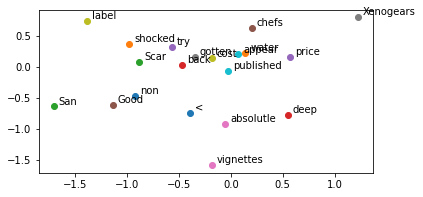

In [39]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocabs[:20]): #loop each unique vocab
    x, y = get_embed_negative(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

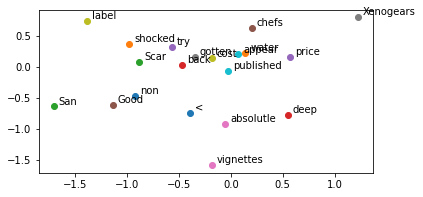

In [40]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocabs[:20]): #loop each unique vocab
    x, y = get_embed_negative(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## Similarity test

In [41]:
def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim

In [42]:
def test_senario_Negative(a1 , a2) :
    tester1 = get_embed_negative(a1)
    teater2 = get_embed_negative(a2)
    print(f"{a1} similarity to {a2} = {cos_sim(tester1 , teater2)}")

In [43]:
def test_senario_nomal(a1 , a2) :
    tester1 = get_embed_normal(a1)
    teater2 = get_embed_normal(a2)
    print(f"{a1} similarity to {a2} = {cos_sim(tester1 , teater2)}")

In [46]:
test_senario_Negative("Japan","English")
test_senario_Negative("price","price")
test_senario_Negative("gamer","Awful") #Because romantic is not awful na krub

Japan similarity to English = -0.9139452779675148
price similarity to price = 1.0000000000000002
gamer similarity to Awful = 0.9673975585035623


In [47]:
test_senario_nomal("Japan","English")
test_senario_nomal("price","price")
test_senario_nomal("gamer","Awful") #Because romantic is not awful na krub

Japan similarity to English = 0.9797983695430756
price similarity to price = 1.0
gamer similarity to Awful = 0.9808852601470673
